# EUROSAT Diffusion

### Envrionment Set Up

In [2]:
!pip install -U diffusers[training] #in case collab resets

In [1]:
!pip install -U datasets huggingface_hub fsspec


  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)


In [26]:
from huggingface_hub import notebook_login

notebook_login()

!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Loading the Dataset

In [4]:
# REMOVE any old copy
!rm -rf /content/EuroSAT

# COPY cleanly
#!cp -r /content/drive/MyDrive/data/eurosat-dataset/6/EuroSAT /content/
!cp -r /content/drive/MyDrive/Thesis_Data/data/eurosat-dataset/6/EuroSAT /content/



In [3]:
from datasets import load_dataset

dataset = load_dataset(
    "imagefolder",
    data_dir="/content/EuroSAT"
)

print(dataset)

Resolving data files:   0%|          | 0/27000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})


In [4]:
dataset["train"] = dataset["train"].shuffle(seed=42).select(
    range(len(dataset["train"]) // 10)
)


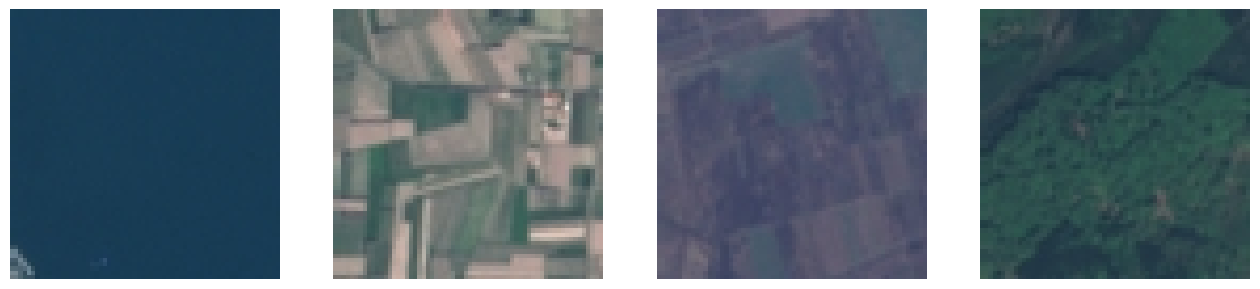

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["image"]):  # Access images from the train set
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

### Preprocessing for Diffusion

In [6]:
from torchvision import transforms

preprocess_diffusion = transforms.Compose([
    #transforms.Resize((256, 256)), #model input unet
    #transforms.CenterCrop(256),
    transforms.ToTensor(), #pytorch tensor for training
    transforms.Normalize([0.5], [0.5]) #normalization
])

def transform(examples):
    images = [preprocess_diffusion(image.convert("RGB")) for image in examples["image"]]
    labels = examples["label"]  # <- Keep the labels
    return {"images": images, "label": labels}
# Apply the batch transform to your dataset
dataset.set_transform(transform)

In [7]:
print(dataset["train"][0])

{'images': tensor([[[-0.8039, -0.8118, -0.8196,  ..., -0.8118, -0.8196, -0.8118],
         [-0.8039, -0.8118, -0.8196,  ..., -0.8118, -0.8196, -0.8118],
         [-0.8118, -0.8118, -0.8118,  ..., -0.8118, -0.8118, -0.8118],
         ...,
         [-0.3569, -0.3647, -0.3961,  ..., -0.8039, -0.8118, -0.8196],
         [-0.0745, -0.0824, -0.3647,  ..., -0.8039, -0.8118, -0.8118],
         [-0.1765, -0.2000, -0.3804,  ..., -0.8118, -0.8118, -0.8118]],

        [[-0.5059, -0.5137, -0.5216,  ..., -0.5294, -0.5373, -0.5294],
         [-0.5059, -0.5137, -0.5216,  ..., -0.5294, -0.5373, -0.5294],
         [-0.5216, -0.5216, -0.5294,  ..., -0.5137, -0.5294, -0.5294],
         ...,
         [-0.1843, -0.1922, -0.2235,  ..., -0.5216, -0.5294, -0.5373],
         [ 0.0588,  0.0588, -0.1922,  ..., -0.5216, -0.5294, -0.5294],
         [-0.0667, -0.0588, -0.2078,  ..., -0.5294, -0.5294, -0.5294]],

        [[-0.3255, -0.3333, -0.3412,  ..., -0.3412, -0.3333, -0.3255],
         [-0.3255, -0.3333, -0.341

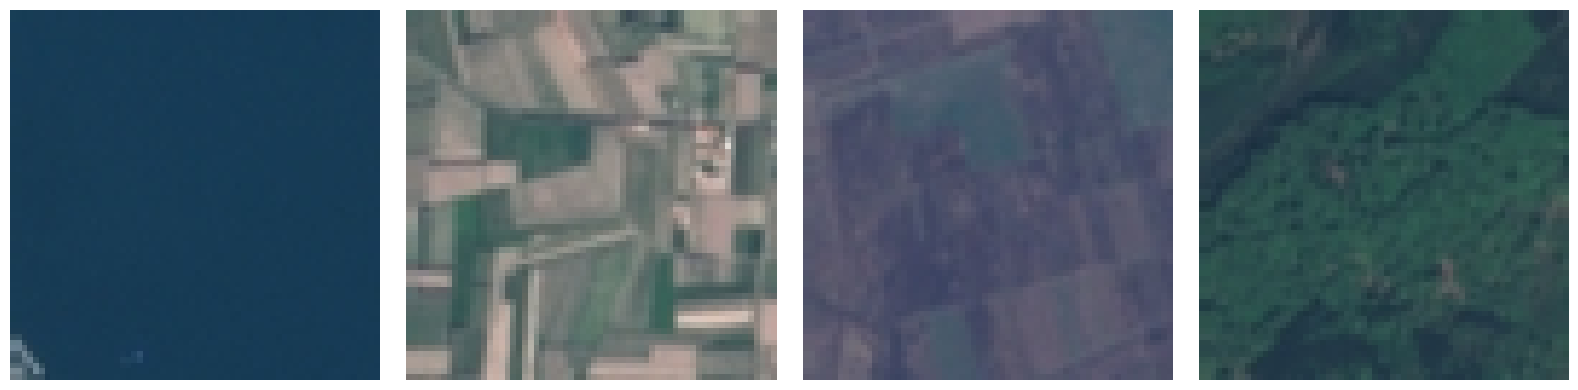

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Load the first 4 samples (batch) from the dataset
batch = dataset["train"][:4]

for i, image in enumerate(batch["images"]):
    # Reverse normalization for display: [-1, 1] → [0, 1]
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
    image = (image * 0.5) + 0.5 #reverse normalization

    axs[i].imshow(image)
    axs[i].set_axis_off()

fig.tight_layout()
plt.show()

## Configuration and Dataloader

In [16]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 100
    eval_batch_size = 100  # 64 ~ 10g ram, 256 for A100
    num_epochs = 45 #feel free to change, since we will always continue the already improved loss with loading the checkpoints. running this code again only improves the model
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 50
    save_image_epochs = 10
    save_model_epochs = 45
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-eurosat-claudia_10'  # the model namy locally and on the HF Hub, WATCH OUT IF RUNNING THE CODE AGAIN

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [17]:
import torch

#train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"],
    batch_size=config.train_batch_size,   # ⚡ BIG BATCH
    shuffle=True,
    num_workers=12,    # ⚡ MORE WORKERS
    pin_memory=True,  # ⚡ FAST CPU → GPU transfer
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
import torch.nn as nn

from diffusers import UNet2DModel
#from diffusers import UNet2DConditionModel


model = UNet2DModel( #CHANGE TO UNet2DModel FOR UNCONDITIONAL
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
    num_class_embeds=10,  # number of classes (e.g., 10 for EuroSAT) COMMENT THIS OUT FOR UNCONDITIONAL
)

In [ ]:
#sample_image = dataset["train"][0]["images"].unsqueeze(0)  # ✅ Correct for your dataset
#print("Input shape:", sample_image.shape)  # Should print (1, 3, 128, 128)

#And let's check the output is a tensor of the same exact shape:
#print('Output shape:', model(sample_image, timestep=0).sample.shape)

## Defining the noise scheduler

In [19]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)



In [20]:
print(dataset['train'])  # if you have a 'train' split

Dataset({
    features: ['image', 'label'],
    num_rows: 2700
})


## Training

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)


In [22]:

from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid
#the below was used in the unconditional one but cannot be used for the conditional one because there is no pipeline label argument to provide labels
'''
def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
'''


'\ndef evaluate(config, epoch, pipeline):\n    # Sample some images from random noise (this is the backward diffusion process).\n    # The default pipeline output type is `List[PIL.Image]`\n    images = pipeline(\n        batch_size = config.eval_batch_size,\n        generator=torch.manual_seed(config.seed),\n    ).images\n\n    # Make a grid out of the images\n    image_grid = make_grid(images, rows=4, cols=4)\n\n    # Save the images\n    test_dir = os.path.join(config.output_dir, "samples")\n    os.makedirs(test_dir, exist_ok=True)\n    image_grid.save(f"{test_dir}/{epoch:04d}.png")\n'

### Loading the HuggingFace model to continue training:

This fetches the model so we have the model locally to continue training!

### Training Loop:

In [ ]:
'''from huggingface_hub import snapshot_download

# Download model folder from the Hub (only once)
snapshot_download(
    repo_id="otausendschoen/ddpm-eurosat-claudia_50",
    local_dir="ddpm-eurosat-conditional-claudia_50",  # must match `config.output_dir`
    repo_type="model",
    local_dir_use_symlinks=False
)
'''

RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-6823248a-22b4557f17fc340b620a0186;b7e51cc0-3f94-4877-8e2f-a3aa929aa4ad)

Repository Not Found for url: https://huggingface.co/api/models/otausendschoen/ddpm-eurosat-claudia_50/revision/main.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication

In [27]:
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # ======================================================
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )
    accelerator.init_trackers("ddpm-eurosat-conditional", init_kwargs={"wandb": {"resume": "allow"}})
    #accelerator.init_trackers("ddpm-eurosat-conditional")
    # ======================================================

    # Prepare everything (model, optimizer, scheduler, dataloader)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    if accelerator.is_main_process:
        repo_id = None  # important: always define repo_id

        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)

    global_step = 0
    epoch_losses = []

    # ======================================================
    # RESUME FROM LOCAL CHECKPOINT
    latest_checkpoint = None
    output_dir = Path(config.output_dir)
    checkpoints = sorted(output_dir.glob("checkpoint_epoch_*"), key=lambda p: int(p.name.split("_")[-1]))
    if checkpoints:
        latest_checkpoint = checkpoints[-1]

    if latest_checkpoint:
        print(f"Resuming from checkpoint: {latest_checkpoint}")
        accelerator.load_state(str(latest_checkpoint))
    # ======================================================

    if accelerator.is_main_process:
        print(f"  Starting training with the following configuration:")
        print(f"   - Number of epochs: {config.num_epochs}")
        print(f"   - Batch size: {config.train_batch_size}")
        print(f"   - Mixed precision: {config.mixed_precision}")
        print(f"   - Output directory: {config.output_dir}")
        print(f"   - Number of training samples: {len(train_dataloader.dataset)}")

    # ======================================================
    # Start training loop
    start_epoch = 0
    if latest_checkpoint:
    # extract last saved epoch number from folder name: checkpoint_epoch_X
      start_epoch = int(latest_checkpoint.name.split("_")[-1]) + 1
    for epoch in range(start_epoch, start_epoch + config.num_epochs):
    #for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        epoch_loss = 0.0
        batches_in_epoch = len(train_dataloader)

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            labels = batch['label']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device).long()

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, class_labels=labels, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.detach().item()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
                "avg_loss": epoch_loss / (step + 1)
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # End of epoch
        avg_epoch_loss = epoch_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)

        if accelerator.is_main_process:
            print(f"\n Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}")
            final_epoch = start_epoch + config.num_epochs - 1

            # ======================
            # Save loss plot
            if (epoch + 1) % 5 == 0 or epoch == final_epoch:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
                plt.title('Training Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.grid(True)
                loss_plot_path = os.path.join(config.output_dir, f"loss_plot_epoch_{epoch}.png")
                os.makedirs(os.path.dirname(loss_plot_path), exist_ok=True)  # ✅ Make sure dir exists
                plt.savefig(loss_plot_path)
                plt.close()
                print(f" Loss plot saved to {loss_plot_path}")
            # ======================

            # ======================
            # 🧹 Save full checkpoint (model + optimizer + scheduler)
            if (epoch + 1) % 5 == 0 or epoch == (start_epoch + config.num_epochs) - 1:
                checkpoint_dir = os.path.join(config.output_dir, f"checkpoint_epoch_{epoch}")
                accelerator.save_state(checkpoint_dir)
                print(f"Checkpoint saved to {checkpoint_dir}")
            # ======================

            # ======================
            # 🖼️ Save generated images
            '''
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Generating sample images for epoch {epoch}...")
                evaluate(config, epoch, pipeline)
            # ======================
            '''
            # ======================
            # 💾 Save full model
            if epoch == final_epoch:
                print(f" Saving model for epoch {epoch}...")
                #pipeline.save_pretrained(config.output_dir)
                accelerator.unwrap_model(model).save_pretrained(config.output_dir)
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*"],#include ,"epoch_*" to safe space on huggingface
                    )
                print(f" Model saved successfully!")
            # ======================


## Let's train

In [28]:
from torch.utils.data import DataLoader

# Ensure the "train" split is correctly accessed
train_dataloader = DataLoader(
    dataset["train"],  # Access the 'train' split
    batch_size=config.train_batch_size,  # Set batch size
    shuffle=True
)

print(dataset.keys())  # Check if 'train' exists as a key



dict_keys(['train'])


In [29]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

#DO NOT RUN THIS IF NOT IN THE CORRECT REPO! EVERYTHING WILL GET OVERWRITTEN
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.
  Starting training with the following configuration:
   - Number of epochs: 45
   - Batch size: 100
   - Mixed precision: fp16
   - Output directory: ddpm-eurosat-claudia_10
   - Number of training samples: 2700


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 0 completed. Average loss: 0.7490


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 1 completed. Average loss: 0.1008


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 2 completed. Average loss: 0.0513


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 3 completed. Average loss: 0.0422


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 4 completed. Average loss: 0.0370
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_4.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_4


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 5 completed. Average loss: 0.0323


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 6 completed. Average loss: 0.0288


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 7 completed. Average loss: 0.0252


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 8 completed. Average loss: 0.0250


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 9 completed. Average loss: 0.0251
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_9.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_9


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 10 completed. Average loss: 0.0232


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 11 completed. Average loss: 0.0205


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 12 completed. Average loss: 0.0204


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 13 completed. Average loss: 0.0194


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 14 completed. Average loss: 0.0195
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_14.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_14


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 15 completed. Average loss: 0.0199


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 16 completed. Average loss: 0.0192


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 17 completed. Average loss: 0.0201


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 18 completed. Average loss: 0.0182


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 19 completed. Average loss: 0.0172
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_19.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_19


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 20 completed. Average loss: 0.0164


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 21 completed. Average loss: 0.0178


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 22 completed. Average loss: 0.0168


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 23 completed. Average loss: 0.0167


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 24 completed. Average loss: 0.0177
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_24.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_24


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 25 completed. Average loss: 0.0180


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 26 completed. Average loss: 0.0179


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 27 completed. Average loss: 0.0180


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 28 completed. Average loss: 0.0169


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 29 completed. Average loss: 0.0175
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_29.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_29


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 30 completed. Average loss: 0.0168


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 31 completed. Average loss: 0.0167


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 32 completed. Average loss: 0.0159


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 33 completed. Average loss: 0.0169


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 34 completed. Average loss: 0.0168
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_34.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_34


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 35 completed. Average loss: 0.0171


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 36 completed. Average loss: 0.0161


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 37 completed. Average loss: 0.0155


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 38 completed. Average loss: 0.0165


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 39 completed. Average loss: 0.0158
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_39.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_39


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 40 completed. Average loss: 0.0170


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 41 completed. Average loss: 0.0162


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 42 completed. Average loss: 0.0167


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 43 completed. Average loss: 0.0164


  0%|          | 0/27 [00:00<?, ?it/s]


 Epoch 44 completed. Average loss: 0.0162
 Loss plot saved to ddpm-eurosat-claudia_10/loss_plot_epoch_44.png
Checkpoint saved to ddpm-eurosat-claudia_10/checkpoint_epoch_44
 Saving model for epoch 44...


optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

Upload 48 LFS files:   0%|          | 0/48 [00:00<?, ?it/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

events.out.tfevents.1747837855.d336b56304ef.24391.0:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

events.out.tfevents.1747837930.d336b56304ef.24391.1:   0%|          | 0.00/211k [00:00<?, ?B/s]

 Model saved successfully!


## Print the loss

In [30]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

log_dir = os.path.join(config.output_dir, "logs", "ddpm-eurosat-conditional")  # adjust if needed
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

print("Available scalar tags:")
print(event_acc.Tags()["scalars"])


Available scalar tags:
['loss', 'lr', 'step', 'avg_loss']


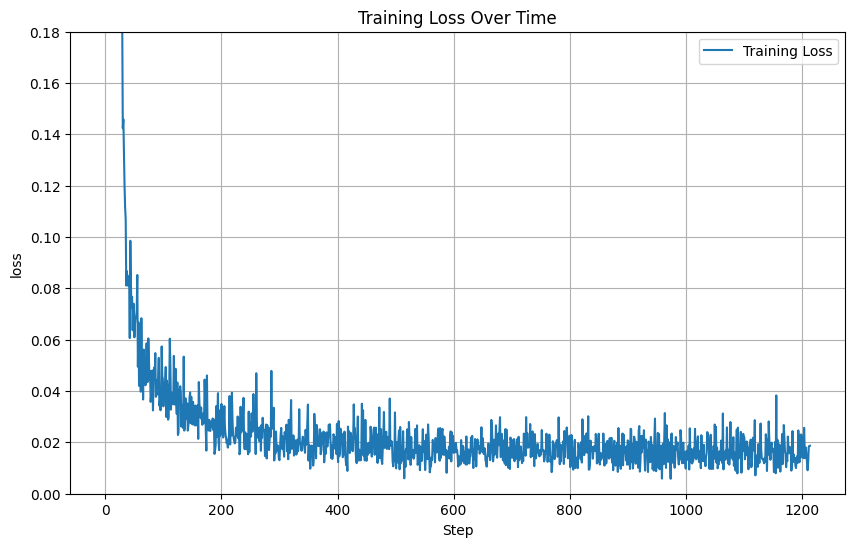

In [31]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import pandas as pd
import matplotlib.pyplot as plt


# Load TensorBoard log
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Extract loss values
loss_events = event_acc.Scalars('loss')
steps = [e.step for e in loss_events]
losses = [e.value for e in loss_events]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel("Step")
plt.ylabel("loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.ylim(0,0.18)
plt.legend()
plt.show()


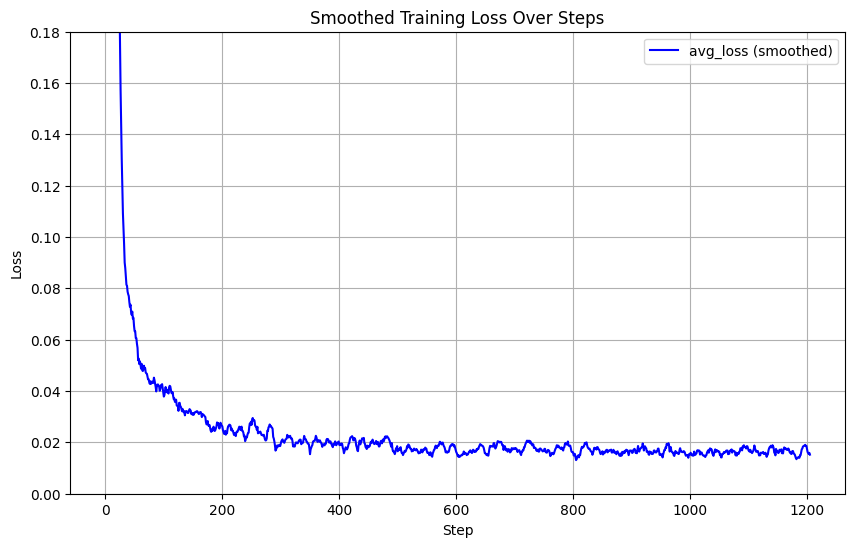

In [32]:
import numpy as np

def smooth_curve(values, window_size=10):
    """Smooths values using a simple moving average."""
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')


smoothed_losses = smooth_curve(losses)

# For proper alignment with steps (same length)
steps_smoothed = steps[:len(smoothed_losses)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps_smoothed, smoothed_losses, label='avg_loss (smoothed)', color='blue')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss Over Steps")
plt.ylim(0, 0.18)
plt.grid(True)
plt.legend()
plt.show()



## Sample some images

In [33]:
from diffusers import DDPMPipeline

# Rebuild pipeline manually from your UNet + scheduler
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

# Save it cleanly
#pipeline.save_pretrained("ddpm-eurosat-claudia")
#pipeline = DDPMPipeline.from_pretrained("ddpm-eurosat-claudia")
pipeline = pipeline.to("cuda")


In [34]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def generate_class_conditional_images(model, noise_scheduler, class_labels, image_size=64, seed=42):
    model.eval()
    batch_size = len(class_labels)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    x = torch.randn(batch_size, 3, image_size, image_size, device="cuda", generator=generator)
    timesteps = torch.full((batch_size,), noise_scheduler.config.num_train_timesteps - 1, device="cuda", dtype=torch.long)#initializes the timesteps for all images as a torch array. eg (tensor([999, 999, 999, 999, 999, 999, 999, 999], device='cuda:0'))
    ##REVERSE DIFFUSION:
    for t in range(noise_scheduler.config.num_train_timesteps - 1, -1, -1): #loop through all timesteps, starting from intiial timestep(-1 to go backward)
        timesteps.fill_(t) #creates the tensore filled with the current timesteps so basically the same as above
        with torch.no_grad():
            noise_pred = model(x, timesteps, class_labels=class_labels).sample
        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images


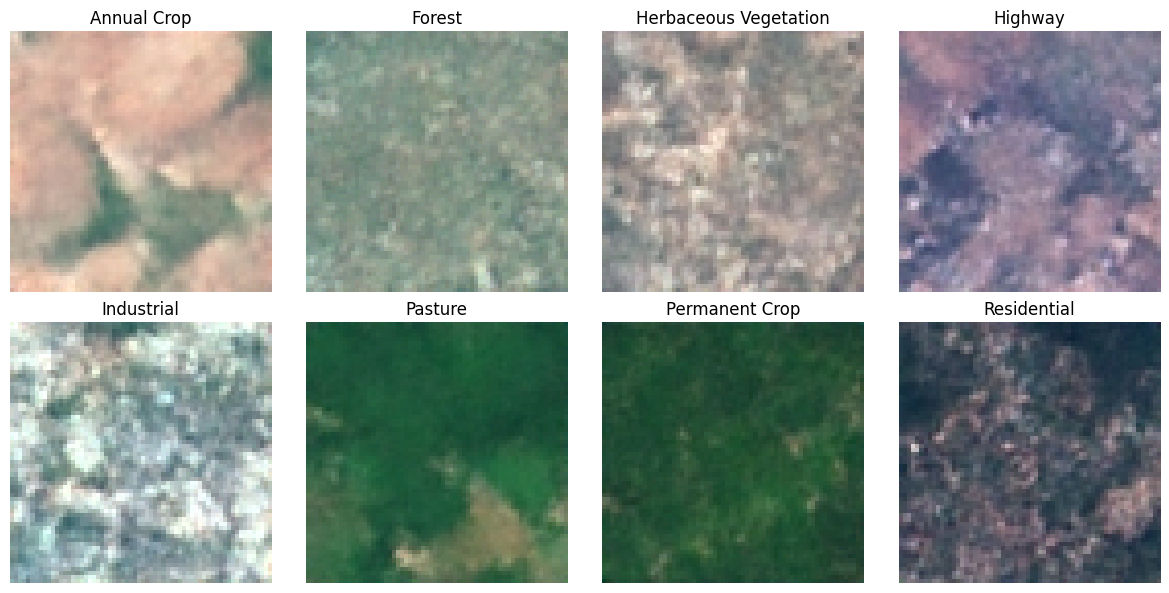

In [36]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Assuming your model + scheduler and generate_class_conditional_images() are set up

labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7], device="cuda")
images = generate_class_conditional_images(model, noise_scheduler, class_labels=labels)

batch_size = len(labels)



eurosat_classes = [
    "Annual Crop", "Forest", "Herbaceous Vegetation", "Highway",
    "Industrial", "Pasture", "Permanent Crop", "Residential",
    "River", "Sea/Lake"
]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(batch_size):
    img = transforms.ToPILImage()(images[i].cpu())
    class_name = eurosat_classes[labels[i].item()]
    axs[i//4, i%4].imshow(img)
    axs[i//4, i%4].set_title(class_name)
    axs[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()

